<h5 style="color:blue;">Auteurs: Mamadou NDIAYE et Ndoffene DIOUF</h5>

# Modélisation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA,KernelPCA
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import scipy.cluster.hierarchy as shc
import pickle

#from yellowbrick.cluster import KElbowVisualizer

## I. Préparation des données

In [2]:
#Vérifier le répertoire de travail
import os
print(os.getcwd()) 
#modifie le répertoire de travail 
pwd = "C:/Users/mamandiaye/Desktop/ANSD/formation/ML/TP_final/data"
os.chdir(pwd)
 
#affiche le nouveau repertoire de travail 
print(os.getcwd())

C:\Users\mamandiaye\Desktop\ANSD\formation\ML\TP_ML_NDIAYE_NDOFFENE\Notebooks
C:\Users\mamandiaye\Desktop\ANSD\formation\ML\TP_final\data


In [3]:
data = pd.read_excel('Base_finale.xlsx')
X_train = pd.read_excel('X_train.xlsx')
X_test = pd.read_excel('X_test.xlsx')

In [4]:
data.shape

(9843, 9)

* **Définition du Pipeline**

In [5]:
# regroupement des varibles selon leur types dans des listes
var_numeric= list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
#var_quali= ["BRANCHE"]

In [6]:
# variables numériques
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler()),
    ])


# variables catégoriel
# onehot_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

In [7]:
preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, var_numeric),
        #("cat", onehot_transformer, var_quali),
    ])
preprocess_pipeline

,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [8]:
X_train=preprocess_pipeline.fit_transform(X_train)
X_test=preprocess_pipeline.fit_transform(X_test)

## II.Modelisation

### II.1 Standardisation des données

La standardisation des données consiste à les centrer autour de leur moyenne et à les réduire à une échelle commune. Cela permet de rendre les variables comparables et de s'assurer que l'ACP ne soit pas influencée par les différences d'échelle entre les variables. Il est important de standardiser les données avant de les utiliser dans l'ACP car cela permet de mettre toutes les variables sur la même échelle. Ainsi, une variable qui a des valeurs plus élevées ne dominera pas une variable avec des valeurs plus faibles lors de la détermination des clusters. Cela peut également améliorer la performance de nos algorithmes en réduisant le temps de calcul (voir *preprocess_pipeline* ci dessus où on a utilsier la méthode StandardScaler de Sklearn pour la standardisation. 

### II.2 Réduction de dimention

Vu la matrice de correlation en 2.3, on va donc tester KernelPCA sur les données la Réduction de dimention.

In [9]:
pca = KernelPCA(n_components = 2, kernel = 'rbf')
X_pca = pca.fit_transform(X_train)
X_pca_test=pca.fit_transform(X_test)

### II. 3 K-means 

Testons d'abord un modèle avec k=5.

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)

In [11]:
kmeans.fit(X_pca)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [12]:
# Calcul des labels prédits
labels = kmeans.labels_
# Calcul du score de silhouette
score = silhouette_score(X_pca, labels)
print("Silhouette Score_train:", score)

Silhouette Score_train: 0.47430122647797396


Avec un score de silhouette de **0,47**, on peut conlure que, relativement, les clusters existent mais ils ne sont pas très bien distincts ou sont un peu chevauchants. Essayons donc de définir le nombre de clusters optimal par la méthode de coude.
On peut donc améliorer le modèle en optimisant ses paramètres.

In [13]:
from yellowbrick.cluster import KElbowVisualizer

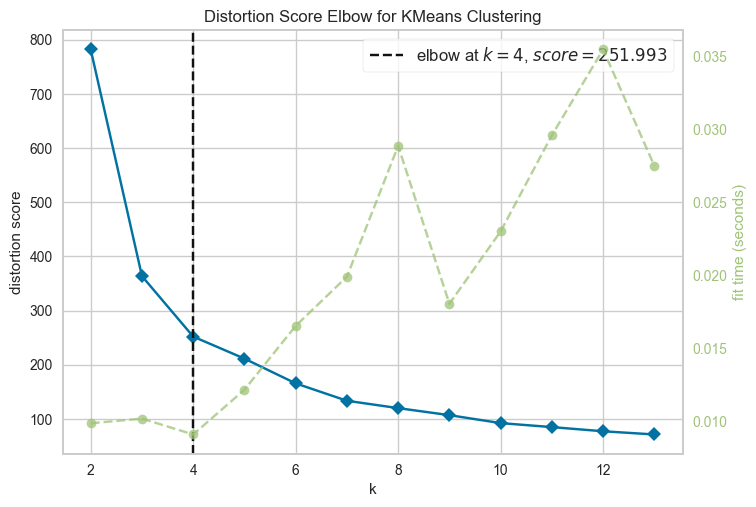

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
## Méthode de coude
kmeans=KMeans()

visualizer= KElbowVisualizer(kmeans, k=(2,14), metric='distortion')
#ON APPLIQUE NOTRE VISUALISER SUR NOTRE JEU DE DONNEES
visualizer.fit(X_pca)

##affichage du graphe coude

visualizer.show()

#### II.3.1 Optimisation des paramètres du modèle

In [15]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]
best_score = -1
best_params = {}
init_methods =['k-means++', 'random']
for k in k_values:
    for init in init_methods:
        kmeans = KMeans(n_clusters=k, init=init, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        if score > best_score:
            best_score = score
            best_params = {"k": k, "init": init}
 
print("Meilleurs paramètres :", best_params)
print("Meilleur silhouette score :", best_score)

Meilleurs paramètres : {'k': 3, 'init': 'random'}
Meilleur silhouette score : 0.5500944366204857


#### II.3.2 Entrainement du meilleurs modèles

In [16]:
kmeans = KMeans(n_clusters=3, init='random', random_state=42)

In [17]:
labels_kmean=kmeans.fit_predict(X_pca)

* **Sur les données d'entrainement**

In [18]:
sil_score = silhouette_score(X_pca, labels_kmean)
calinski_score = calinski_harabasz_score(X_pca, labels_kmean)

print(f"Score Silhouette_train : {sil_score:.4f}")

Score Silhouette_train : 0.5501


* **Sur les données test**

In [19]:
kmeans.fit(X_pca_test)
# Calcul des labels prédits
labels_test = kmeans.fit_predict(X_pca_test)
# Calcul du score de silhouette
sil_score_test = silhouette_score(X_pca_test, labels_test)
calinski_score_test = calinski_harabasz_score(X_pca_test, labels_test)

print(f"Score Silhouette_test : {sil_score_test:.4f}")

Score Silhouette_test : 0.5373


### II. 4. Classification Ascendante Hierarchique

Pour cette partie on va tester le clustering hiérarchique. Elle a la contrainte de ne pas requérir de définir à l’avance le nombre de clusters, ce qui permet d’explorer toutes les possibilités le long du dendrogramme. Cependant, il faut généralement prendre cette décision à un moment. Il est possible pour cela d’utiliser un dendrogramme, pour y déceler un « niveau » auquel les clusters sont clairement distants les uns des autres. Nous allons, toutefois, opter pour une solution alternative qui est d’évaluer les différents modèles pour différentes valeurs de k et vérifier la partition optimale à l’aide d’une mesure de performance telle que le coefficient de silhouette. 
    

#### II.4.1 Determination du nmbre de clusters optimal

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
Z = linkage(X_pca,method='ward',metric='euclidean')
best_score = -1
best_k = None

for k in range(2, 14):  # par exemple de 2 à 10 clusters
    clusters = fcluster(Z, t=k, criterion="maxclust")
    score = silhouette_score(X_pca, clusters)
    print(f"Nombre de clusters : {k} - Score silhouette : {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score silhouette = {best_score:.2f}")

Nombre de clusters : 2 - Score silhouette : 0.4257
Nombre de clusters : 3 - Score silhouette : 0.5204
Nombre de clusters : 4 - Score silhouette : 0.4551
Nombre de clusters : 5 - Score silhouette : 0.4037
Nombre de clusters : 6 - Score silhouette : 0.3895
Nombre de clusters : 7 - Score silhouette : 0.3731
Nombre de clusters : 8 - Score silhouette : 0.4048
Nombre de clusters : 9 - Score silhouette : 0.3873
Nombre de clusters : 10 - Score silhouette : 0.3777
Nombre de clusters : 11 - Score silhouette : 0.3721
Nombre de clusters : 12 - Score silhouette : 0.3643
Nombre de clusters : 13 - Score silhouette : 0.3671
Meilleur nombre de clusters : 3 avec un score silhouette = 0.52


#### II.4.2 Estimation du meilleur modèle

Le modèle CAH à 3 clusters est retenu comme le meilleur modèle. Nous allons donc visualiser le dendrogramme afin de deceler le le seuil optimal qui nous donnes une partition de 3 classes 

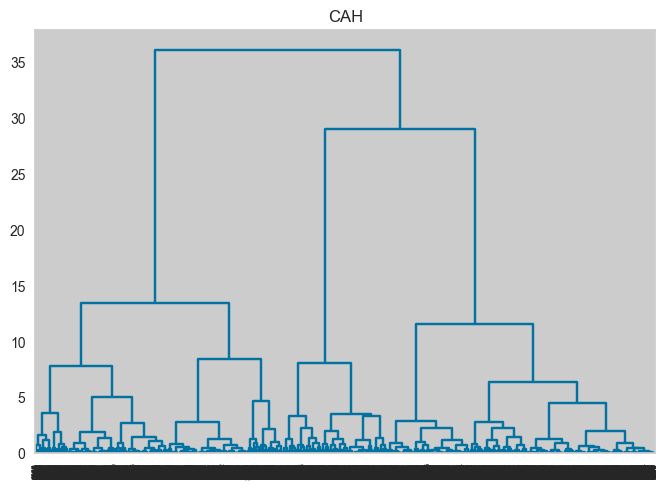

In [21]:
Z = linkage(X_pca,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,orientation='top',color_threshold=0)
plt.show()

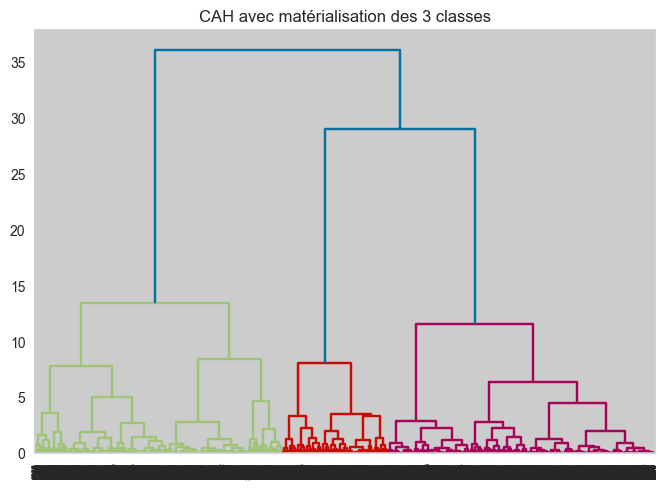

[3 1 1 ... 1 2 2]


In [22]:
plt.title('CAH avec matérialisation des 3 classes')
dendrogram(Z,orientation='top',color_threshold=15)
plt.show()
groupes_cah = fcluster(Z,t=3,criterion='maxclust')
print(groupes_cah)
#index triés des groupes
idg = np.argsort(groupes_cah)

In [23]:
# Calcul des scores sur les données d'entrainement
sil_score = silhouette_score (X_pca, groupes_cah)
ch_score = calinski_harabasz_score(X_pca, groupes_cah)

print(f"Score Silhouette CAH train : {sil_score:.4f}")
print(f"Score Calinski-Harabasz CAH train : {ch_score:.4f}")

Score Silhouette CAH train : 0.5204
Score Calinski-Harabasz CAH train : 9116.0923


In [24]:
# Calcul des scores sur les données tests
Ztest = linkage(X_pca_test,method='ward',metric='euclidean')
groupes_cahtest = fcluster(Ztest,t=3,criterion='maxclust')
sil_score = silhouette_score(X_pca_test, groupes_cahtest)
ch_score = calinski_harabasz_score(X_pca_test, groupes_cahtest)

print(f"Score Silhouette CAH test : {sil_score:.4f}")
print(f"Score Calinski-Harabasz CAH test : {ch_score:.4f}")

Score Silhouette CAH test : 0.5060
Score Calinski-Harabasz CAH test : 3683.9097


### II. 5 DBSCAN

In [33]:
# DBSCAN sur les données s
dbscan = DBSCAN(eps=0.6, min_samples=4)
dbscan_clusters = dbscan.fit_predict(X_pca)

#### II.5.1 Optimisation

In [34]:
eps_values = np.linspace(0.1, 3.0, 8)        # différents eps
min_samples_values = [1,2, 3, 4, 5, 6, 7, 8, 9]      # différents min_samples

best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)

        # Éviter les cas où tout est bruit ou un seul cluster
        if len(set(labels)) > 1 and -1 not in set(labels):
            score = silhouette_score(X_pca, labels)
            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}

print("Meilleurs paramètres :", best_params)
print("Score silhouette :", best_score)

Meilleurs paramètres : {}
Score silhouette : -1


Le DBSCAN ne semble pas fonctionner sur les données. On peut donc l'exclure du choix du melleur modèle.m

#### II.5.2 Entrainement du meilleur modèle

In [ ]:
# dbs = DBSCAN(eps = 0.1, 
#              min_samples=4).fit(X_pca)

In [ ]:
#labels_dbscan = dbs.labels_

## III. Choix du meilleur modèle

In [35]:
# Calcul des scores
scores = {
    'KMeans': {
        'Silhouette': silhouette_score(X_pca, labels_kmean),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, labels_kmean)
    },
    'CAH': {
        'Silhouette': silhouette_score(X_pca, groupes_cah),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, groupes_cah)
    },
#     'DBSCAN': {
#         'Silhouette': silhouette_score(X_pca, labels_dbscan),
#         'Calinski-Harabasz': calinski_harabasz_score(X_pca, labels_dbscan)
#     }
    }

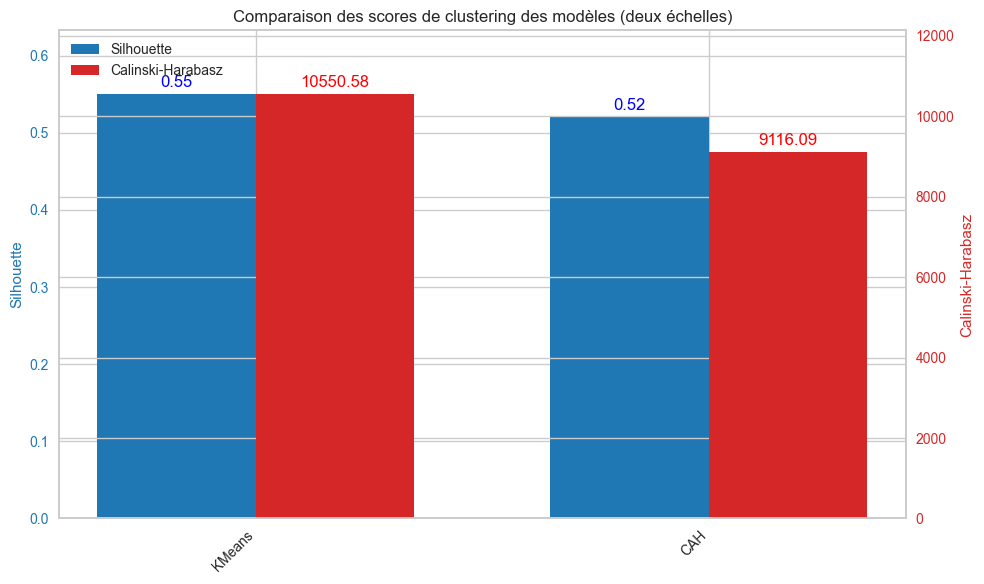

In [36]:
model_names = list(scores.keys())
sil_scores = [scores[m]['Silhouette'] for m in model_names]
ch_scores = [scores[m]['Calinski-Harabasz'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

#Silhouette
rects1 = ax1.bar(x - width/2, sil_scores, width, label='Silhouette', color='tab:blue')
ax1.set_ylabel('Silhouette', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(sil_scores) * 1.15)

#Calinski-Harabasz
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, ch_scores, width, label='Calinski-Harabasz', color='tab:red')
ax2.set_ylabel('Calinski-Harabasz', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(ch_scores) * 1.15)

#Étiquettes et titre
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_title('Comparaison des scores de clustering des modèles (deux échelles)')

# Légendes combinées
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Ajout des valeurs sur les barres (facultatif)
def autolabel(rects, ax, color):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', color=color)

autolabel(rects1, ax1, 'blue')
autolabel(rects2, ax2, 'red')

plt.tight_layout()
plt.show()

## IV. Entrainement du modèle finale

### IV 1. Entrainement du modèle finale sur l'ensemble des données

In [37]:
df=preprocess_pipeline.fit_transform(data)

In [38]:
pca=KernelPCA(n_components=2)
df_pca = pca.fit_transform(df)

In [39]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

In [40]:
kmeans.fit(df_pca)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [41]:
#garder les cluster dans une variable
clusters_kmeans=kmeans.labels_

In [42]:
data["clusters"]=clusters_kmeans

### IV. 2. Caractérisation des clusters

In [43]:
cols=["Rentabilité Fin", "Autonomie Fin","impot_VA", "tx fiscale", "svblité", "VALEUR AJOUTEE (XB + RA + RB) + (somme TE à RJ)","CAPITAL", "clusters" ]
df=data[cols]

In [44]:
##calcul des différents moyenne par clusters
Xt_kmean1=df.groupby(['clusters']).mean()
Xt_kmean=df.groupby(['clusters']).mean().reset_index().melt(id_vars='clusters', value_vars=cols, var_name='variable', value_name='mean')
Xt_kmean1

,Rentabilité Fin,Autonomie Fin,impot_VA,tx fiscale,svblité,VALEUR AJOUTEE (XB + RA + RB) + (somme TE à RJ),CAPITAL
clusters,,,,,,,
0,254.020228,694.605877,1.875778,0.351615,2441.589553,7.734925e+07,2.230136e+07
1,1183.862552,98.554124,17.221542,3.856438,2252.452730,1.094223e+08,2.002701e+07
2,5541.708250,18.411022,5.326758,1.332100,292.413430,7.447305e+09,1.892025e+09


<Figure size 1200x600 with 0 Axes>

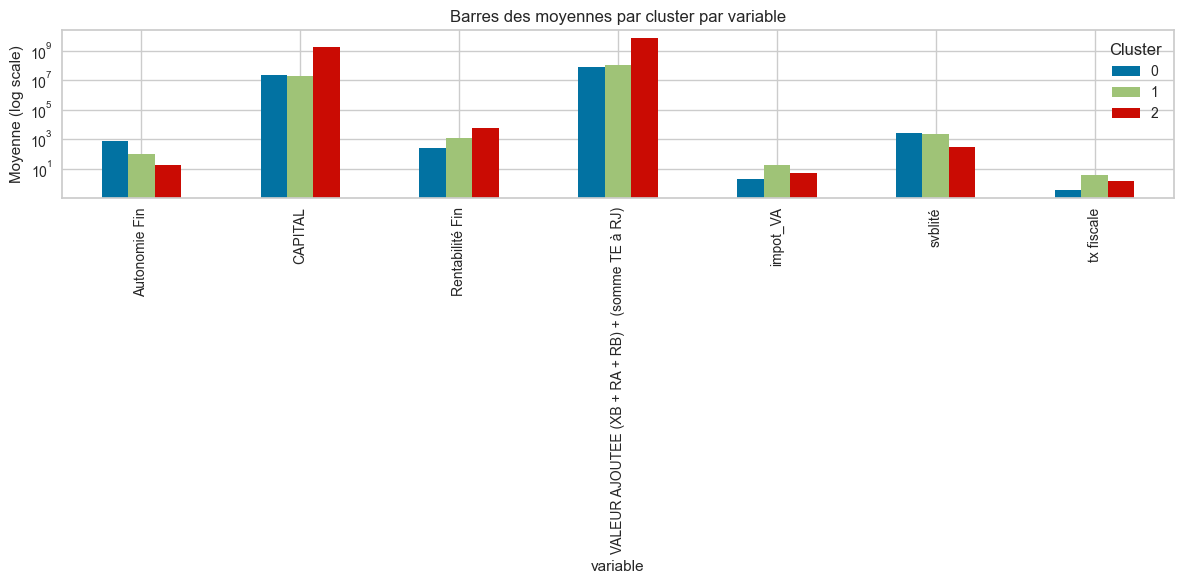

In [45]:
plt.figure(figsize=(12,6))
ax = Xt_kmean.pivot(index='variable', columns='clusters', values='mean').plot(
    kind='bar', figsize=(12,6)
)
plt.ylabel('Moyenne (log scale)')
plt.yscale('log')
plt.title('Barres des moyennes par cluster par variable')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### IV. 3 Interprétation 

* **Groupe 1 (Les entreprises fragiles):**

**Caractéristiques**: Groupe d'entreprises avec une rentabilité insuffisante pour assurer une forte autonomie financière; dépendance potentielle à des financements externes et pression fiscale non négligeable .

* **Groupe 2 (Les entreprises stables)**

**Caractéristiques**: Groupe d'entreprises avec une rentabilité supérieure à celle du groupe 1. La Valeur Ajoutée (VA) est plus important. Les entreprises de ce groupe sont relativement plus solides avec une meilleure capacité à s'autofinancer via leurs capitaux propres

* **Groupe 3 (Les grandes entreprises)**

**Caractéristiques**: Groupe d'entreprises rentabilité très élevée, autonomie financière élevée, indice fiscal élevé mais avec une valeur ajoutée et un capital conséquents. On observe vraisemblablement une concentration de ressources et une forte capacité d’autofinancement.

### IV. 4 Sauvegarder le modèle pour le déploiement

In [46]:
pickle.dump(kmeans, open('model_final.pkl','wb'))

In [47]:
open('model_final.pkl','wb').close()